## Data loading

In [1]:
import pandas as pd
import numpy as np

all_data = pd.read_pickle('data/all_data.pkl')

## Define functions

### Selecting data by model

In [ ]:
def select_data(df_in, model=1):

    vars_full = ['PFAS_class'] + [
            "sex", "age", "waist"
        ] + ["sbp", "htn_med", "BPb", "BHg", "Uhg", "MEHHP", "MEOHP", "MCPP", "MEP", "BPA", "MP"
             ] + ["WBC", "EOS", "RBC", "PLT", "HB", "ALT", "AST", "GGT", "CHOL", "HDL"
              ] +  ["fryingpan", "coatingpot", "coatingcase", "ricepot", "fridge_case", "freezer_case", "water"
            ] + ['cupnoodle', 'microwave_food', 'popcorn', 'can_food', 'large_fish', 'fish', 'crustacean', 'shellfish'
                 ] + ['OHP', 'NAP', 'OHFlu', 'OHPhe', 'MnBP', 'MECPP', 'MBzP', 'BPF', 'BPS', 'TCS', 'EP', 'PP', 'BP', # added
            'fast_food', 'wrapped_food', 'paper_cup', 'pet_drink', # added
            'BMI']

    vars = list(dict.fromkeys(vars_full))
    df = df_in.dropna(subset=vars_full, how='any')
    
    if model == 1:
        # vars = ['PFAS_class'] + [
            # "gender", "age", "height", "weight", "waist", "sbp", "dbp", "htn_med", "BPb", "BHg", "Uhg", "MEHHP", "MEOHP", "MCPP", "MEP", "BPA", "MP", "BP_3", "COT", "tt_MA", "PBA", "U_crea", "S_crea", "WBC", "EOS", "RBC", "PLT", "HB", "HCT", "HbA1c", "ALT", "AST", "GGT", "CHOL", "HDL", "TG", "T_lipid", "S_crea", "U_crea", "SG", "T_IgE", "fryingpan", "coatingpot", "coatingcase", "ricepot", "fridge_case", "freezer_case", "water"
            # ] + ['smoking', 'water_type', 'cupnoodle', 'microwave_food', 'popcorn', 'can_food', 'large_fish', 'fish', 'crustacean', 'shellfish'] # Initial version
        vars = vars_full
    elif model == 2:
        vars = ['PFAS_class'] + ["WBC", "RBC", "PLT", "HB", "sex", "age", "BMI", "waist", "AST", "ALT"]
    elif model == 0:
        vars = df.columns.tolist()  # Use all variables for model 0

    vars = list(dict.fromkeys(vars))
    df = df[vars]
    df = df.loc[:, ~df.columns.duplicated()]

    # Convert DEHP metabolites to molar concentration and calculate sum
    dehp_metabolites = ['MEHHP', 'MEOHP', 'MECPP']
    molecular_weights = {'MEHHP': 278.33, 'MEOHP': 292.32, 'MECPP': 308.31}  # g/mol

    # Check if all three variables exist
    if all(col in df.columns for col in dehp_metabolites):
        # Convert μg/L to μmol/L (concentration / molecular weight)
        for metabolite in dehp_metabolites:
            df[f'{metabolite}_umol'] = df[metabolite] / molecular_weights[metabolite]
    
        # Calculate sum of molar concentrations
        df['DEHP_sum'] = df['MEHHP_umol'] + df['MEOHP_umol'] + df['MECPP_umol']
        df.drop(columns=['MEHHP', 'MEOHP', 'MECPP', 'MEHHP_umol', 'MEOHP_umol', 'MECPP_umol'], inplace=True, errors='ignore')

    return df


### Handling missing values

In [3]:
def handle_missing_values(df, threshold_ratio=0):
    df_copy = df.copy()
    missing_ratio = df_copy.isnull().sum(axis=1) / len(df_copy.columns)

    df_copy = df_copy[missing_ratio <= threshold_ratio]

    categorical_columns = df_copy.select_dtypes(exclude=[np.number]).columns

    for col in categorical_columns:
        df_copy[col] = df_copy[col].fillna(df_copy[col].mode()[0])

    for col in df_copy.columns:
        if pd.api.types.is_numeric_dtype(df_copy[col]):
            continue
        
        if df_copy[col].dtype == 'object' and df_copy[col].notna().all():
            try:
                df_copy[col] = df_copy[col].astype(float)
                
            except ValueError:
                print(f"Column '{col}' contains non-numeric values and could not be converted.")

    return df_copy

### One-hot encoding

In [4]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

def preprocess_mixed_data(X):

    X = pd.DataFrame(X)
    
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object', 'category']).columns
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ])
    
    X_processed = preprocessor.fit_transform(X)
    
    onehot_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    new_columns = list(numeric_features) + list(onehot_columns)
    
    X_processed_df = pd.DataFrame(X_processed, columns=new_columns, index=X.index)

    X_processed_df.drop(columns=['freezer_case_plastic'], inplace=True, errors='ignore')

    return X_processed_df, preprocessor

### Age interaction term

In [5]:
import pandas as pd
import numpy as np

def add_age_interactions(X, age_column='age'):
    
    X_new = X.copy()
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    onehot_columns = X.columns[X.isin([0, 1]).all()]
    interaction_columns = [col for col in numeric_columns if col != age_column and col not in onehot_columns]

    for col in interaction_columns:
        new_col_name = f'{age_column}_x_{col}'
        X_new[new_col_name] = X[age_column] * X[col]
    
    return X_new

## ML Models

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_classif

### Setting gridsearch parameters

In [7]:
def set_pipeline(model, i_model, random_state=42):
    
    # logistic
    if model == 'Logistic':
        pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=random_state)),
            ('classifier', LogisticRegression(random_state=random_state, solver='saga', max_iter=5000, tol=1e-2, penalty='elasticnet', warm_start=True))
        ])
        param_grid = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'classifier__l1_ratio': [0, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9, 1],
            'classifier__max_iter': [1000, 3000, 5000],
        }

    # random forest
    elif model == 'Random Forest':
        pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=random_state)),
            ('rf', RandomForestClassifier(random_state=random_state))
        ])
        param_grid = {
            'rf__bootstrap': [True, False],
            'rf__n_estimators': [200, 400],
            'rf__max_depth': [3, 4, 5, 6, 7, 8, 9],
            'rf__min_samples_split': [2, 3, 4],
            'rf__min_samples_leaf': [10, 12, 14, 16, 18],
            'rf__max_features': ['sqrt', 'log2'],
        }
    
    # GBM
    elif model == 'GBM':
        pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=random_state)),
            ('gb', GradientBoostingClassifier(random_state=random_state))
        ])
        param_grid = {
            'gb__n_estimators': [200, 400],
            'gb__learning_rate': [0.01, 0.1, 0.3],
            'gb__min_samples_split': [2, 3, 5, 10],
            'gb__min_samples_leaf': [2, 4, 8, 12],
        }
    
    # XGBoost
    elif model == 'XGBoost':
        pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=random_state)),
            ('xgb', XGBClassifier(random_state=random_state))
        ])
        param_grid = {
            'xgb__max_depth': [2, 3, 4, 5],
            'xgb__learning_rate': [0.001, 0.005, 0.01, 0.1],
            'xgb__n_estimators': [200, 400, 500],
            'xgb__min_child_weight': [3, 5, 7, 8, 9, 10, 11],
        }

    # SVM
    elif model == 'SVM':
        pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=random_state)),
            ('classifier', SVC(random_state=random_state, probability=True, kernel='rbf'))
        ])
        param_grid = {
            'classifier__C': [0.01, 1, 1e3, 1e6],
            'classifier__gamma': [1e-7, 1e-6, 1e-3, 1],
        }

    elif model == 'KNN':
        pipeline = ImbPipeline([
            ('selector', SelectKBest(score_func=mutual_info_classif)),
            ('classifier', KNeighborsClassifier())
        ])
        if i_model == 1:
            k_values = [10, 12, 15, 18, 20]
        elif i_model == 2:
            k_values = [10]
            
        param_grid = {
            # 'selector__k': [3, 4, 5, 6, 7, 8, 9, 10],
            'selector__k': k_values,
            'classifier__n_neighbors': [10, 12, 14, 16, 18, 20],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__metric': ['euclidean', 'manhattan'],
        }

    return pipeline, param_grid

### Grid Search function

In [8]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def grid_search_wrapper(X_train, y_train, pipeline, param_grid, model_name, n_splits=5, random_state=42, n_jobs=-1, log=True):
    
    print(f'\nGrid Search for {model_name}')

    scoring = {
        'f1': make_scorer(f1_score),
        'balanced_accuracy': make_scorer(balanced_accuracy_score),
        'accuracy': make_scorer(accuracy_score),
        'roc_auc': make_scorer(roc_auc_score, response_method='predict_proba', multi_class='ovr'),
    }

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state) # setup stratified K-fold

    grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring=scoring, n_jobs=n_jobs, refit='balanced_accuracy', return_train_score=True) # grid search
    grid_search.fit(X_train, y_train)

    if log:
        print("Best parameters:", grid_search.best_params_)

    # Train, test scores from grid search with K-fold CV
    metrics = {}
    for metric in scoring.keys():
        test_scores = grid_search.cv_results_[f'mean_test_{metric}']
        train_scores = grid_search.cv_results_[f'mean_train_{metric}']
        best_index = grid_search.best_index_
        metrics[metric] = {
            'mean': test_scores[best_index],
            'std': grid_search.cv_results_[f'std_test_{metric}'][best_index],
            'train_mean': train_scores[best_index],
            'train_std': grid_search.cv_results_[f'std_train_{metric}'][best_index]
        }

    # print results
    if log:
        for metric, values in metrics.items():
            print(f"{metric.capitalize()}:")
            print(f"  Test:  {values['mean']:.4f} (± {values['std']:.4f})")
            print(f"  Train: {values['train_mean']:.4f} (± {values['train_std']:.4f})")

    metrics = format_metrics(metrics)

    return grid_search.best_estimator_, metrics

def format_metrics(metrics):
    formatted_metrics = {
        'f1': (metrics['f1']['mean'], metrics['f1']['std']),
        'balanced_accuracy': (metrics['balanced_accuracy']['mean'], metrics['balanced_accuracy']['std']),
        'accuracy': (metrics['accuracy']['mean'], metrics['accuracy']['std']),
        'roc_auc': (metrics['roc_auc']['mean'], metrics['roc_auc']['std']),
        'train_f1': (metrics['f1']['train_mean'], metrics['f1']['train_std']),
        'train_balanced_accuracy': (metrics['balanced_accuracy']['train_mean'], metrics['balanced_accuracy']['train_std']),
        'train_accuracy': (metrics['accuracy']['train_mean'], metrics['accuracy']['train_std']),
        'train_roc_auc': (metrics['roc_auc']['train_mean'], metrics['roc_auc']['train_std']),
    }
    return formatted_metrics

### Evaluate model

In [9]:
import scipy.stats

def evaluate_model(best_model, X_test, y_test, log=False):
    
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    y_len = y_test.shape[0]
    
    metrics = {}
    metrics['f1'] = f1_score(y_test, y_pred)
    metrics['balanced_accuracy'] = balanced_accuracy_score(y_test, y_pred)
    metrics['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
    metrics['accuracy'] = accuracy_score(y_test, y_pred)

    if log:
        print("\nTest Metrics:")
        for metric_name, metric_value in metrics.items():
            ci = normal_confidence_interval(metric_value, y_len)
            print(f"{metric_name.upper()}: {metric_value:.4f} (± {ci:.4f})")

    return metrics

# normal approximation interval
def normal_confidence_interval(metric, length, confidence=0.95):
    z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)
    ci = z_value * np.sqrt((metric * (1 - metric)) / length)
    
    return ci

# recording data for grid search
def update_results_grid(results, model_name, i_model, metrics):
    for metric, (mean, std) in metrics.items():
        results[metric].loc[model_name, f'Model_{i_model}_Mean'] = mean
        results[metric].loc[model_name, f'Model_{i_model}_Std'] = std

def update_results_test(results, model_name, i_model, metrics, length):
    for metric_name, metric_value in metrics.items():
        results.append({
            'model': i_model,
            'algorithm': model_name,
            'metric': metric_name,
            'mean': metric_value,
            'std': normal_confidence_interval(metric_value, length)
        })

    return results

### Display metrics

In [10]:
def display_result_test(results):
    desired_order = ['Logistic', 'Random Forest', 'GBM', 'XGBoost', 'SVM', 'KNN']

    for metric in results['metric'].unique():
        metric_data = results[results['metric'] == metric]
        pivot = pd.pivot_table(metric_data,
                               values=['mean', 'std'],
                               index='algorithm',
                               columns='model',
                               aggfunc='first')
        
        def format_row(row):
            formatted = []
            for model in pivot.columns.get_level_values('model').unique():
                mean = row[('mean', model)]
                std = row[('std', model)]
                formatted.append(f"{mean:.3f} (± {std:.3f})")
            return pd.Series(formatted)

        formatted = pivot.apply(format_row, axis=1)
        formatted.columns = [f'model_{i+1}' for i in range(len(formatted.columns))]
        formatted.index.name = None
        
        formatted = formatted.reindex(desired_order)
        print(f"\n{metric.upper()} Scores for Test set")
        print(formatted.to_string(index=True))

def display_result_gridsearch(results):
    pd.set_option('display.width', 1000)
    formatted_results = {}
    
    for metric, df in results.items():
        model_nums = set()
        for col in df.columns:
            if col.startswith('Model_') and col.endswith('_Mean'):
                model_num = int(col.split('_')[1])
                model_nums.add(model_num)
        
        model_nums = sorted(list(model_nums))
        
        formatted_df = pd.DataFrame(index=df.index, 
                                  columns=[f'Model_{i}' for i in model_nums])
        
        for model in df.index:
            for i in model_nums:
                mean = df.loc[model, f'Model_{i}_Mean']
                std = df.loc[model, f'Model_{i}_Std']
                formatted_df.loc[model, f'Model_{i}'] = f"{mean:.3f} (± {std:.3f})"
                
        formatted_results[metric] = formatted_df
    
    for metric, df in formatted_results.items():
        print(f"\n{metric.upper()} Scores for GridSearchCV:")
        print(df)

## Statistics

### Statistical Logistic Regression

In [11]:
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import StandardScaler

i_model = 2

df = select_data(all_data, model=i_model)
df = handle_missing_values(df, threshold_ratio=0)

print(df.shape)
X = df.drop('PFAS_class', axis=1)
X, preprocessor = preprocess_mixed_data(X)
y = df['PFAS_class'].map({'expose': 1, 'none': 0})

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_sm = sm.add_constant(X_scaled)

model = sm.Logit(y, X_sm)
results = model.fit()

print(results.summary())


(3782, 11)
Optimization terminated successfully.
         Current function value: 0.396623
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             PFAS_class   No. Observations:                 3782
Model:                          Logit   Df Residuals:                     3771
Method:                           MLE   Df Model:                           10
Date:                Mon, 28 Jul 2025   Pseudo R-squ.:                  0.3291
Time:                        16:37:36   Log-Likelihood:                -1500.0
converged:                       True   LL-Null:                       -2235.9
Covariance Type:            nonrobust   LLR p-value:                3.056e-310
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5159      0.056     26.867      0.000       1.405       1.626
WBC            0.0

### Correlation: all

Reordered variable list:
['PFAS_class_1', 'age', 'sex_Male', 'BMI', 'waist', 'sbp', 'htn_med_yes', 'WBC', 'RBC', 'PLT', 'HB', 'EOS', 'ALT', 'AST', 'GGT', 'CHOL', 'HDL', 'BPb', 'BHg', 'Uhg', 'OHP', 'NAP', 'OHFlu', 'OHPhe', 'DEHP_sum', 'MnBP', 'MBzP', 'MCPP', 'MEP', 'MP', 'BPA', 'BPF', 'BPS', 'TCS', 'EP', 'PP', 'BP', 'large_fish', 'fish', 'crustacean', 'shellfish', 'cupnoodle', 'microwave_food', 'popcorn', 'can_food', 'fast_food', 'wrapped_food', 'paper_cup', 'pet_drink', 'fryingpan', 'coatingpot', 'coatingcase', 'ricepot', 'fridge_case_metal', 'fridge_case_others', 'fridge_case_plastic', 'fridge_case_ziploc', 'freezer_case_metal', 'freezer_case_others', 'freezer_case_ziploc', 'water_filter', 'water_others', 'water_spring', 'water_tap', 'water_well']


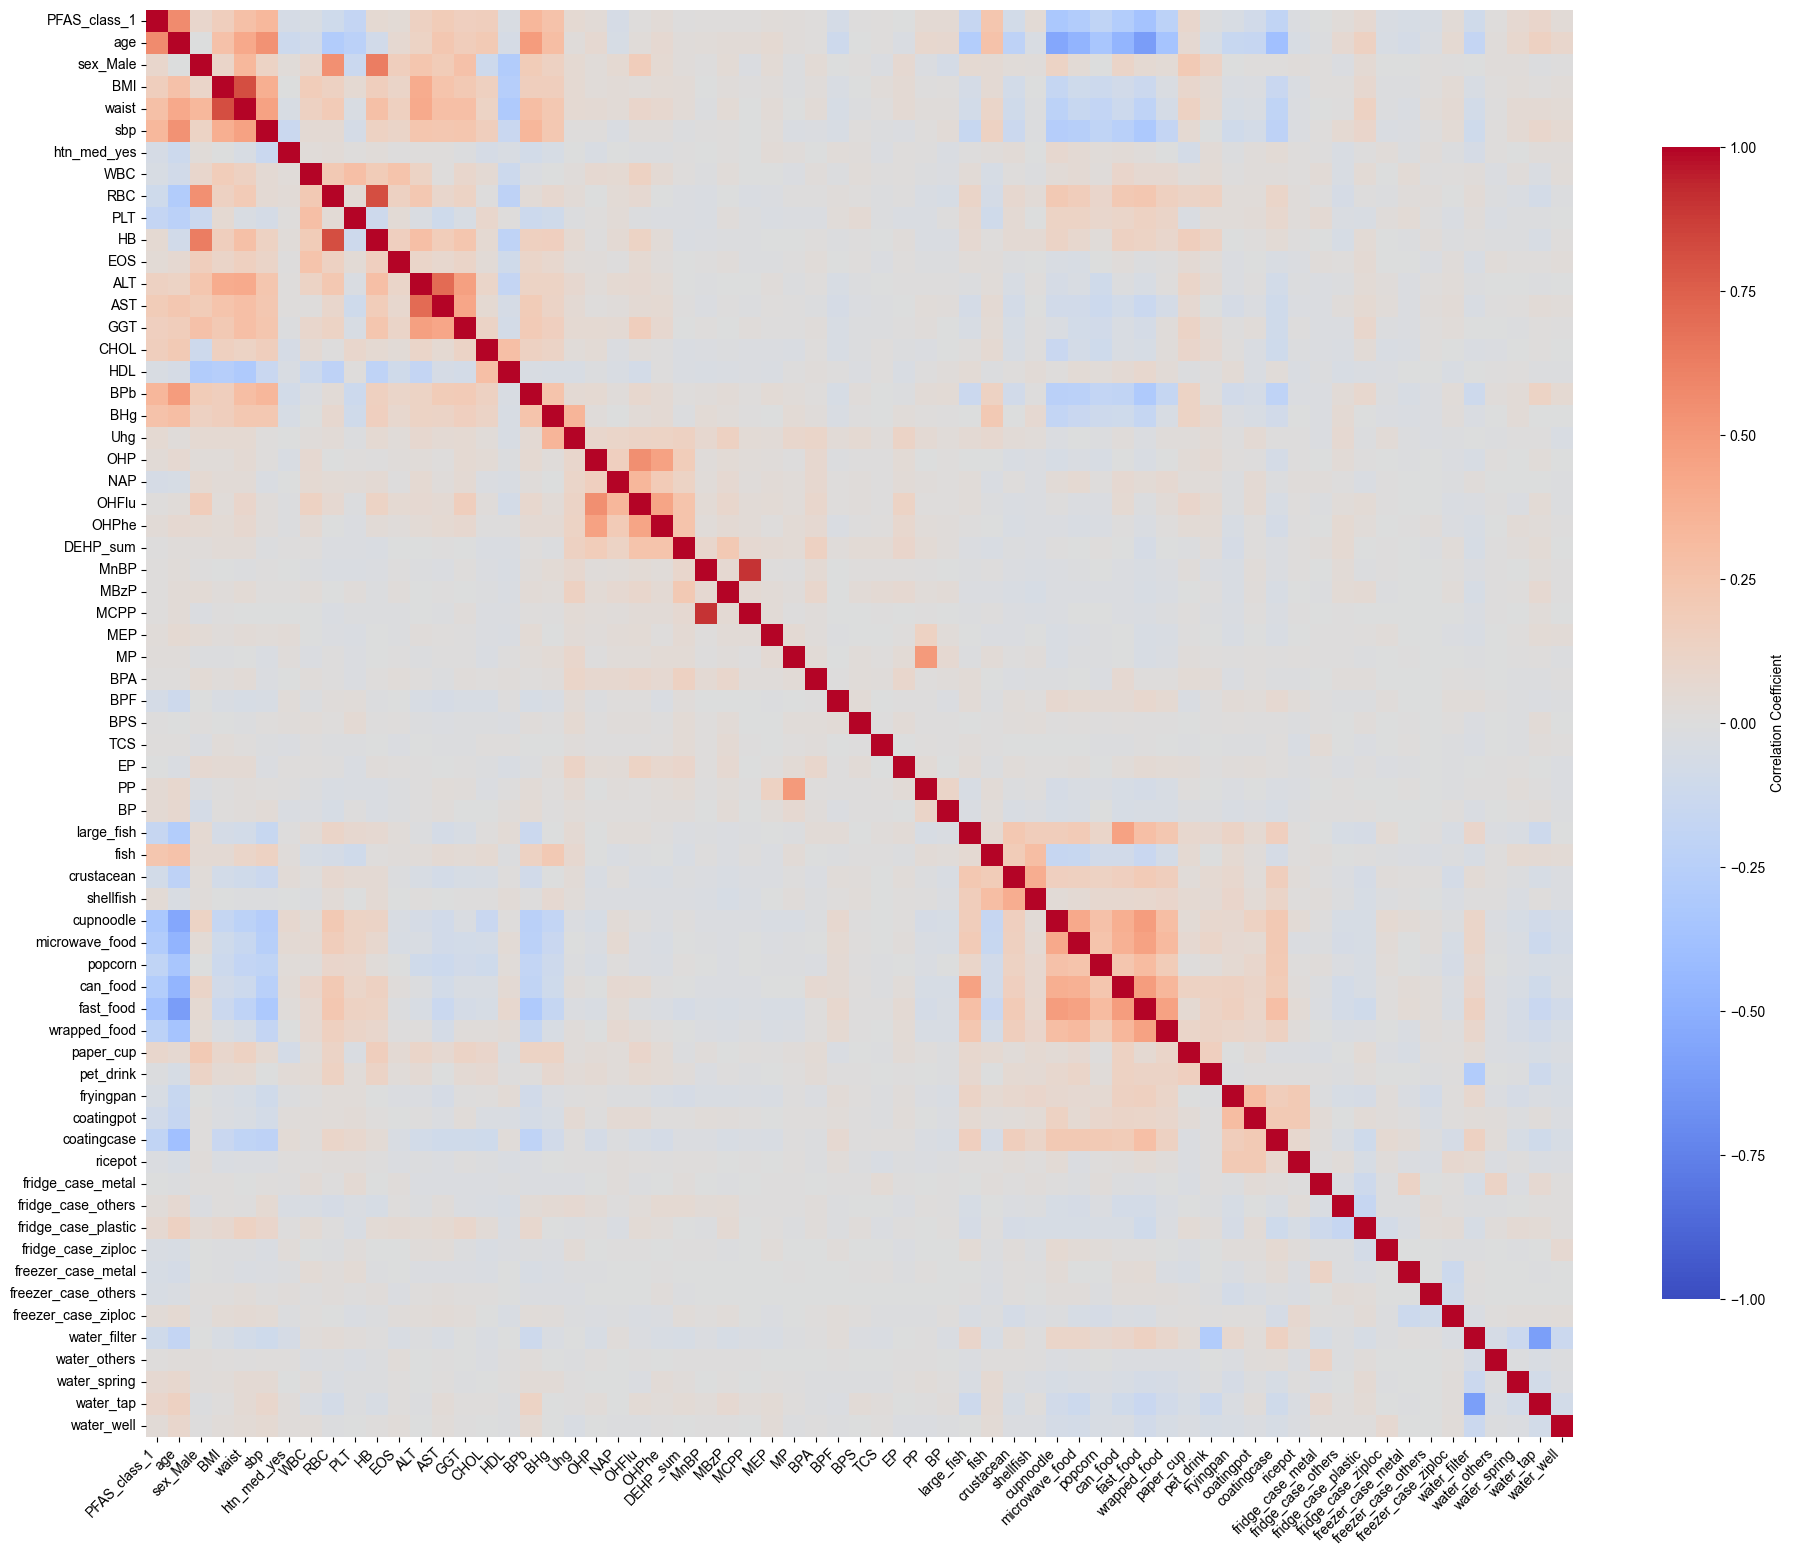

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'arial'

i_model = 1

df_corr = select_data(all_data, i_model)
df_corr = handle_missing_values(df_corr, threshold_ratio=0)
df_corr['PFAS_class'] = df_corr['PFAS_class'].map({'expose': 1, 'none': 0})
df_corr, processor = preprocess_mixed_data(df_corr)

# Manual variable ordering by category
desired_order = [
    'PFAS_class_1', # Target variable
    'age', 'sex_Male', 'BMI', 'waist', # Demographic variables
    'sbp', 'htn_med_yes', # Blood pressure related
    'WBC', 'RBC', 'PLT', 'HB', 'EOS', # Blood tests
    'ALT', 'AST', 'GGT', 'CHOL', 'HDL', # Biochemical tests
    'BPb', 'BHg', 'Uhg', # Heavy metals
    'OHP', 'NAP', 'OHFlu', 'OHPhe', # Metabolites
    'DEHP_sum', 
    'MnBP', 'MBzP', 'MCPP', 'MEP', 'MP', # Phthalates
    'BPA', 'BPF', 'BPS', 'TCS', 'EP', 'PP', 'BP', # Other chemical compounds
    'large_fish', 'fish', 'crustacean', 'shellfish',
    'cupnoodle', 'microwave_food', 'popcorn', 'can_food', # Processed foods
    'fast_food', 'wrapped_food', 'paper_cup', 'pet_drink', # Fast food and packaged items
    'fryingpan', 'coatingpot', 'coatingcase', 'ricepot', # Cooking utensils
    'fridge_case_metal', 'fridge_case_others', 'fridge_case_plastic', 'fridge_case_ziploc', # Refrigerator storage containers
    'freezer_case_metal', 'freezer_case_others', 'freezer_case_ziploc', # Freezer storage containers
    'water_filter', 'water_others', 'water_spring', 'water_tap', 'water_well', # Water sources
]

# Filter variables that actually exist in the dataset
available_vars = [var for var in desired_order if var in df_corr.columns]
remaining_vars = [var for var in df_corr.columns if var not in available_vars]
final_order = available_vars + remaining_vars

# Reorder the dataframe
df_corr = df_corr[final_order]

vars = df_corr.columns.tolist()
print("Reordered variable list:")
print(vars)

# Generate correlation matrix
correlation_matrix = df_corr.corr()
n_vars = len(correlation_matrix.columns)
fig_size = max(15, n_vars * 0.3)

# Create heatmap
plt.figure(figsize=(fig_size, fig_size))
sns.heatmap(correlation_matrix,
            annot=False,
            cmap='coolwarm',
            center=0,
            square=True,
            vmin=-1,
            vmax=1,
            cbar_kws={'label': 'Correlation Coefficient', 'shrink': 0.6},
            xticklabels=True,
            yticklabels=True)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.savefig('figure/pdf/heatmap_manual_order.pdf', bbox_inches='tight')
plt.savefig('figure/heatmap_manual_order.png', bbox_inches='tight', dpi=600)
plt.show()

### Correlation: age, sex, CBC

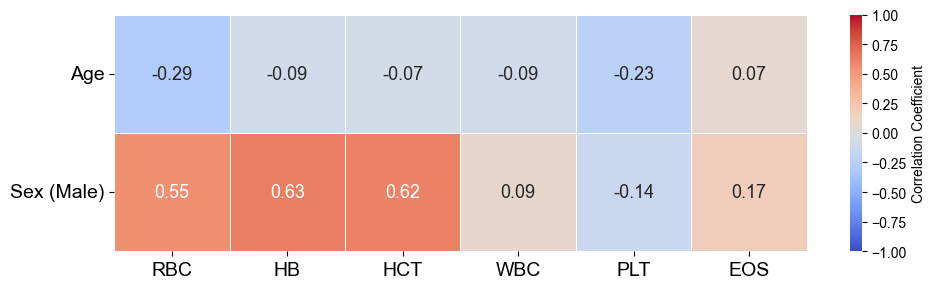

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'arial'

i_model = 0

# Data preparation
df_corr = select_data(all_data, i_model)
df_corr = handle_missing_values(df_corr, threshold_ratio=0)
df_corr['PFAS_class'] = df_corr['PFAS_class'].map({'expose': 1, 'none': 0})
df_corr, processor = preprocess_mixed_data(df_corr)

# Select age, sex and CBC variables
demographic_vars = ['age', 'sex_Male']  # Variables for rows
cbc_vars = ['RBC', 'HB', 'HCT', 'WBC', 'PLT', 'EOS']  # Variables for columns

# Filter variables that exist in the dataset
available_demographic = [var for var in demographic_vars if var in df_corr.columns]
available_cbc = [var for var in cbc_vars if var in df_corr.columns]

# Create correlation matrix between demographic and CBC variables
selected_vars = available_demographic + available_cbc
correlation_subset = df_corr[selected_vars].corr()

# Extract correlations between demographic variables (rows) and CBC variables (columns)
age_sex_cbc_corr = correlation_subset.loc[available_demographic, available_cbc]

# Create heatmap
plt.figure(figsize=(10, 3))
sns.heatmap(age_sex_cbc_corr,
            annot=True,  # Show correlation values
            fmt='.2f',   # Format to 3 decimal places
            cmap='coolwarm',
            center=0,
            square=False,  # Rectangular shape
            vmin=-1,
            vmax=1,
            cbar_kws={'label': 'Correlation Coefficient', 'shrink': 1},
            xticklabels=True,
            yticklabels=True,
            linewidths=0.5,
            annot_kws={'size': 13})

# plt.title('Correlation between Age/Sex and CBC Parameters', fontsize=14, pad=20)
# plt.xlabel('CBC Parameters', fontsize=12)
# plt.ylabel('Demographic Variables', fontsize=12)
plt.xticks(rotation=0, ha='center', fontsize=14)
plt.yticks(rotation=0, fontsize=14)

# Update y-axis labels for better readability
y_labels = ['Age', 'Sex (Male)'] if 'sex_Male' in available_demographic else ['Age']
if len(available_demographic) == len(y_labels):
    plt.gca().set_yticklabels(y_labels)

plt.tight_layout()

# Save figures
plt.savefig('figure/pdf/age_sex_cbc_correlation.pdf', bbox_inches='tight')
plt.savefig('figure/age_sex_cbc_correlation.png', bbox_inches='tight', dpi=600)
plt.show()

### VIF

In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def calculate_vif(df):
    """VIF calculation function"""
    # Add constant term (for intercept)
    X = add_constant(df)
    
    # Calculate VIF
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Remove constant term (delete const row)
    vif_data = vif_data[vif_data['Variable'] != 'const']
    
    # Sort by VIF values (descending order)
    vif_data = vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)
    
    return vif_data

# VIF calculation
i_model = 1

df_VIF = select_data(all_data, i_model)
df_VIF = handle_missing_values(df_VIF, threshold_ratio=0)
df_VIF['PFAS_class'] = df_VIF['PFAS_class'].map({'expose': 1, 'none': 0})
df_VIF, processor = preprocess_mixed_data(df_VIF)
df_VIF = df_VIF.drop(columns=['PFAS_class_1'], errors='ignore')  # Exclude PFAS_class

print(df_VIF.columns)

# statistics
# print((df_VIF['freezer_case_ziploc'] == 1).sum())
# print((df_VIF['freezer_case_plastic'] == 1).sum())

vif_results = calculate_vif(df_VIF)

# Print results
print("VIF Analysis Results:")
print("=" * 50)
print(vif_results)

# Classification for VIF interpretation
print("\n" + "=" * 50)
print("VIF Interpretation:")
print("VIF < 5: Low multicollinearity")
print("5 ≤ VIF < 10: Moderate multicollinearity") 
print("VIF ≥ 10: High multicollinearity (problematic)")

# Number of variables in each category
low_vif = vif_results[vif_results['VIF'] < 5]
moderate_vif = vif_results[(vif_results['VIF'] >= 5) & (vif_results['VIF'] < 10)]
high_vif = vif_results[vif_results['VIF'] >= 10]

print(f"\nLow multicollinearity (VIF < 5): {len(low_vif)} variables")
print(f"Moderate multicollinearity (5 ≤ VIF < 10): {len(moderate_vif)} variables")
print(f"High multicollinearity (VIF ≥ 10): {len(high_vif)} variables")

# Print variables with moderate VIF (5-10)
if len(moderate_vif) > 0:
    print(f"\nVariables with moderate VIF (5-10):")
    for idx, row in moderate_vif.iterrows():
        print(f"  {row['Variable']}: {row['VIF']:.2f}")

# Print variables with high VIF (≥10)
if len(high_vif) > 0:
    print(f"\nVariables with high VIF (≥ 10):")
    for idx, row in high_vif.iterrows():
        print(f"  {row['Variable']}: {row['VIF']:.2f}")


# ===== CSV Export Section =====

# Save VIF results to CSV
filename = f"result/vif_results.csv"
vif_results.to_csv(filename, index=False, encoding='utf-8-sig')
print(f"\nVIF results saved to: {filename}")

Index(['age', 'waist', 'sbp', 'BPb', 'BHg', 'Uhg', 'MCPP', 'MEP', 'BPA', 'MP',
       'WBC', 'EOS', 'RBC', 'PLT', 'HB', 'ALT', 'AST', 'GGT', 'CHOL', 'HDL',
       'fryingpan', 'coatingpot', 'coatingcase', 'ricepot', 'cupnoodle',
       'microwave_food', 'popcorn', 'can_food', 'large_fish', 'fish',
       'crustacean', 'shellfish', 'OHP', 'NAP', 'OHFlu', 'OHPhe', 'MnBP',
       'MBzP', 'BPF', 'BPS', 'TCS', 'EP', 'PP', 'BP', 'fast_food',
       'wrapped_food', 'paper_cup', 'pet_drink', 'BMI', 'DEHP_sum', 'sex_Male',
       'htn_med_yes', 'fridge_case_metal', 'fridge_case_others',
       'fridge_case_plastic', 'fridge_case_ziploc', 'freezer_case_metal',
       'freezer_case_others', 'freezer_case_ziploc', 'water_filter',
       'water_others', 'water_spring', 'water_tap', 'water_well'],
      dtype='object')
VIF Analysis Results:
               Variable       VIF
0                  MnBP  5.485177
1                  MCPP  5.433773
2                 waist  4.556483
3                    HB  

### Statistics table

In [42]:
import pandas as pd
import numpy as np
from scipy import stats

i_model = 0

df_stat = select_data(all_data, model=0)
# df_stat = handle_missing_values(df_stat, threshold_ratio=0)

df_stat['PFAS_class'] = df_stat['PFAS_class'].map({'expose': 1, 'none': 0})
df_stat['sex'] = df_stat['sex'].map({'Male': 1, 'Female': 0})

print(df_stat.shape)


(3782, 74)


In [45]:
import pandas as pd
import numpy as np
from scipy import stats

def create_simple_table(df_stat, exposure_var='PFAS_class'):
    """
    Create a simple population characteristics table
    """
    # Frequency variables (1-3: Rare, 4-6: 1-6/week, 7-9: 1-3/day)
    freq_categories = {1: 'Rare', 2: 'Rare', 3: 'Rare',
                      4: '1-6/week', 5: '1-6/week', 6: '1-6/week',
                      7: '1-3/day', 8: '1-3/day', 9: '1-3/day'}
    
    # Recode frequency variables
    for var in ['fryingpan', 'coatingpot', 'coatingcase', 'ricepot']:
        df_stat[f'{var}_recoded'] = df_stat[var].map(freq_categories)
    
    # Water source mapping (string values to categories)
    water_categories = {'tap': 'Tap', 'filter': 'Filtered', 'bottled': 'Bottled', 
                       'spring': 'Spring', 'well': 'Well', 'others': 'Others'}
    
    df_stat['water_recoded'] = df_stat['water'].map(water_categories)
    
    # Split data by exposure level (after recoding)
    low = df_stat[df_stat[exposure_var] == 0]
    high = df_stat[df_stat[exposure_var] == 1]
    total = df_stat
    
    results = []
    
    # Gender analysis (male)
    def add_gender():
        low_male = (low['sex'] == 1).sum()
        high_male = (high['sex'] == 1).sum()
        total_male = (total['sex'] == 1).sum()
        
        _, p_val = stats.chi2_contingency([[low_male, len(low)-low_male], 
                                          [high_male, len(high)-high_male]])[:2]
        
        results.append(['Gender', 'Male', 
                       f"{low_male} ({low_male/len(low)*100:.1f})",
                       f"{high_male} ({high_male/len(high)*100:.1f})",
                       f"{total_male} ({total_male/len(total)*100:.1f})",
                       f"<0.001" if p_val < 0.001 else f"{p_val:.3f}"])
    
    # Continuous variables
    def add_continuous(var, name):
        low_data = low[var].dropna().astype(float)
        high_data = high[var].dropna().astype(float)
        total_data = total[var].dropna().astype(float)
        
        _, p_val = stats.ttest_ind(low_data, high_data)
        
        results.append([name, '',
                       f"{low_data.mean():.2f} ± {low_data.std():.2f}",
                       f"{high_data.mean():.2f} ± {high_data.std():.2f}",
                       f"{total_data.mean():.2f} ± {total_data.std():.2f}",
                       f"<0.001" if p_val < 0.001 else f"{p_val:.3f}"])
    
    # Categorical variables
    def add_categorical(var, name, categories):
        contingency = []
        first_cat = True
        
        # Process categories in order
        if isinstance(categories, dict):
            category_items = categories.items()
        else:
            category_items = [(cat, cat) for cat in categories]
        
        for cat_val, cat_name in category_items:
            low_count = (low[var] == cat_val).sum()
            high_count = (high[var] == cat_val).sum()
            total_count = (total[var] == cat_val).sum()
            
            # Add only if data exists
            if low_count > 0 or high_count > 0:
                contingency.append([low_count, high_count])
                
                results.append([name if first_cat else '', cat_name,
                               f"{low_count} ({low_count/len(low)*100:.1f})",
                               f"{high_count} ({high_count/len(high)*100:.1f})",
                               f"{total_count} ({total_count/len(total)*100:.1f})",
                               ''])
                first_cat = False
        
        # Add p-value
        if len(contingency) > 1:
            _, p_val = stats.chi2_contingency(np.array(contingency).T)[:2]
            p_value_str = f"<0.001" if p_val < 0.001 else f"{p_val:.3f}"
            # Add p-value to the first category
            for i in range(len(results)-1, -1, -1):
                if results[i][0] == name:
                    results[i][5] = p_value_str
                    break
    
    # Add variables
    # Sample size
    results.append(['Samples', '',
                   f"{len(low)}",
                   f"{len(high)}",
                   f"{len(total)}",
                   ''])
    
    add_gender()
    add_continuous('height', 'Height')
    add_continuous('weight', 'Weight')
    add_continuous('BMI', 'BMI')
    add_continuous('waist', 'Waist')
    add_continuous('age', 'Age (years)')
    
    # Add hematological variables
    add_continuous('HB', 'Hemoglobin (g/dL)')
    add_continuous('HCT', 'Hematocrit (%)')
    add_continuous('RBC', 'Red blood cells (×10⁶/μL)')
    add_continuous('WBC', 'White blood cells (×10³/μL)')
    add_continuous('PLT', 'Platelets (×10³/μL)')
    add_continuous('EOS', 'Eosinophils (mm³)')
    
    add_categorical('fryingpan_recoded', 'Frying pan use, n (%)', 
                   ['Rare', '1-6/week', '1-3/day'])
    
    add_categorical('coatingpot_recoded', 'Coating pot use, n (%)', 
                   ['Rare', '1-6/week', '1-3/day'])
    
    add_categorical('coatingcase_recoded', 'Coating case use, n (%)', 
                   ['Rare', '1-6/week', '1-3/day'])
    
    add_categorical('ricepot_recoded', 'Rice pot use, n (%)', 
                   ['Rare', '1-6/week', '1-3/day'])
    
    add_categorical('water_recoded', 'Drinking water source, n (%)', 
                   ['Tap', 'Filtered', 'Bottled', 'Spring', 'Well', 'Others'])
    
    # Create DataFrame
    df_results = pd.DataFrame(results, columns=['Variable', 'Category', 'Low_exposure', 
                                               'High_exposure', 'Total_population', 'p_value'])
    
    return df_results

# Usage
df_table = create_simple_table(df_stat)
print(df_table.to_string(index=False))

# Save as CSV
# df_table.to_csv('population_table.csv', index=False)

                    Variable Category    Low_exposure   High_exposure Total_population p_value
                     Samples                     1052            2730             3782        
                      Gender     Male      388 (36.9)     1283 (47.0)      1671 (44.2)  <0.001
                      Height            164.02 ± 8.43   161.97 ± 8.92    162.54 ± 8.83  <0.001
                      Weight            63.23 ± 14.10   65.34 ± 12.02    64.75 ± 12.66  <0.001
                         BMI             23.39 ± 4.20    24.84 ± 3.62     24.43 ± 3.84  <0.001
                       Waist            77.71 ± 11.72   84.78 ± 10.48    82.81 ± 11.29  <0.001
                 Age (years)            25.88 ± 14.38   51.66 ± 17.45    44.48 ± 20.27  <0.001
           Hemoglobin (g/dL)             13.70 ± 1.50    13.89 ± 1.39     13.84 ± 1.43  <0.001
              Hematocrit (%)             41.47 ± 3.98    42.01 ± 3.99     41.86 ± 3.99  <0.001
   Red blood cells (×10⁶/μL)              4.63 ± 0

## Run

### Machine learning

In [ ]:
import time
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

print_log = True
age_interaction = False
random_state = 42

models = ['Logistic', 'Random Forest', 'GBM', 'XGBoost', 'SVM', 'KNN']

results_test = []
metrics_grid = ['f1', 'balanced_accuracy', 'accuracy', 'roc_auc', 'train_f1', 'train_balanced_accuracy', 'train_accuracy', 'train_roc_auc']
results_grid = {metric: pd.DataFrame(index=models) for metric in metrics_grid}

best_models = {}
data_models = {}

start_time = time.time()

# for i_model in range(1, 6):
for i_model in range(1, 3):

    # if i_model != 1:
        # continue

    print(f"\nProcessing Dataset {i_model}")
    df = select_data(all_data, i_model)
    df = handle_missing_values(df, threshold_ratio=0)
    X = df.drop('PFAS_class', axis=1)
    X, preprocessor = preprocess_mixed_data(X)

    if age_interaction:
        X = add_age_interactions(X) # adding interaction terms with age

    y = df['PFAS_class'].map({'expose': 1, 'none': 0})
    print("N rows = ", len(X))

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    data_models[f"Model_{i_model}"] = (X_train, X_test, y_train, y_test)

    # scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # iterate over algorithms
    for model in models:

        # if model != 'Logistic': # this is to test a single model
        # if model != 'Random Forest': # this is to test a single model
        # if model != 'GBM': # this is to test a single model
        # if model != 'XGBoost': # this is to test a single model
        # if model != 'SVM': # this is to test a single model
        # if model != 'KNN': # this is to test a single model
            # continue

        pipeline, params = set_pipeline(model, i_model, random_state=random_state) # set parameters for grid search
        best_model, metrics_grid = grid_search_wrapper(X_train_scaled, y_train, pipeline, params, model, random_state=random_state, log=print_log) # grid search and return results
        metrics_test = evaluate_model(best_model, X_test_scaled, y_test, log=True) # applying the best model on test set

        # recording data
        results_test = update_results_test(results_test, model, i_model, metrics_test, length=y_test.shape[0]) # record the test metrics
        update_results_grid(results_grid, model, i_model, metrics_grid) # record the metrics from grid search
        best_models[f"Model_{i_model}_{model}"] = best_model # record the best model

    # break
    
results_test = pd.DataFrame(results_test)

end_time = time.time()
execution_time = end_time - start_time
print("\nExecution Times (seconds):", execution_time)

# display_result_test(results_test)
# display_result_gridsearch(results_grid)


Processing Dataset 1
N rows =  3782

Grid Search for Logistic
Best parameters: {'classifier__C': 0.1, 'classifier__l1_ratio': 0.8, 'classifier__max_iter': 1000}
F1:
  Test:  0.8619 (± 0.0096)
  Train: 0.8667 (± 0.0037)
Balanced_accuracy:
  Test:  0.8166 (± 0.0129)
  Train: 0.8264 (± 0.0025)
Accuracy:
  Test:  0.8130 (± 0.0122)
  Train: 0.8198 (± 0.0043)
Roc_auc:
  Test:  0.8735 (± 0.0214)
  Train: 0.8917 (± 0.0048)

Test Metrics:
F1: 0.8476 (± 0.0209)
BALANCED_ACCURACY: 0.8145 (± 0.0226)
ROC_AUC: 0.8709 (± 0.0195)
ACCURACY: 0.7982 (± 0.0233)

Grid Search for Random Forest


/home/ihong/anaconda3/envs/py3112/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'rf__bootstrap': True, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 12, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
F1:
  Test:  0.8618 (± 0.0106)
  Train: 0.8805 (± 0.0042)
Balanced_accuracy:
  Test:  0.8069 (± 0.0122)
  Train: 0.8416 (± 0.0052)
Accuracy:
  Test:  0.8111 (± 0.0130)
  Train: 0.8371 (± 0.0052)
Roc_auc:
  Test:  0.8702 (± 0.0182)
  Train: 0.9142 (± 0.0032)

Test Metrics:
F1: 0.8571 (± 0.0204)
BALANCED_ACCURACY: 0.8199 (± 0.0224)
ROC_AUC: 0.8709 (± 0.0195)
ACCURACY: 0.8088 (± 0.0229)

Grid Search for GBM
Best parameters: {'gb__learning_rate': 0.01, 'gb__min_samples_leaf': 2, 'gb__min_samples_split': 2, 'gb__n_estimators': 200}
F1:
  Test:  0.8594 (± 0.0059)
  Train: 0.8726 (± 0.0041)
Balanced_accuracy:
  Test:  0.8083 (± 0.0042)
  Train: 0.8311 (± 0.0043)
Accuracy:
  Test:  0.8088 (± 0.0066)
  Train: 0.8269 (± 0.0049)
Roc_auc:
  Test:  0.8721 (± 0.0177)
  Train: 0.9087 (± 0.0028)

Test Metrics:
F1: 0.8518 (± 0.0207)
BA

/home/ihong/anaconda3/envs/py3112/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'rf__bootstrap': False, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
F1:
  Test:  0.8491 (± 0.0112)
  Train: 0.8531 (± 0.0047)
Balanced_accuracy:
  Test:  0.8145 (± 0.0111)
  Train: 0.8185 (± 0.0024)
Accuracy:
  Test:  0.7998 (± 0.0125)
  Train: 0.8044 (± 0.0052)
Roc_auc:
  Test:  0.8551 (± 0.0176)
  Train: 0.8705 (± 0.0039)

Test Metrics:
F1: 0.8449 (± 0.0211)
BALANCED_ACCURACY: 0.8191 (± 0.0224)
ROC_AUC: 0.8692 (± 0.0196)
ACCURACY: 0.7965 (± 0.0234)

Grid Search for GBM
Best parameters: {'gb__learning_rate': 0.01, 'gb__min_samples_leaf': 8, 'gb__min_samples_split': 2, 'gb__n_estimators': 400}
F1:
  Test:  0.8543 (± 0.0098)
  Train: 0.8698 (± 0.0036)
Balanced_accuracy:
  Test:  0.8060 (± 0.0087)
  Train: 0.8321 (± 0.0049)
Accuracy:
  Test:  0.8032 (± 0.0113)
  Train: 0.8240 (± 0.0045)
Roc_auc:
  Test:  0.8585 (± 0.0142)
  Train: 0.9019 (± 0.0043)

Test Metrics:
F1: 0.8534 (± 0.0206)
B

/home/ihong/anaconda3/envs/py3112/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 5, 'xgb__min_child_weight': 9, 'xgb__n_estimators': 200}
F1:
  Test:  0.8572 (± 0.0111)
  Train: 0.8756 (± 0.0041)
Balanced_accuracy:
  Test:  0.8142 (± 0.0135)
  Train: 0.8419 (± 0.0063)
Accuracy:
  Test:  0.8077 (± 0.0137)
  Train: 0.8319 (± 0.0052)
Roc_auc:
  Test:  0.8588 (± 0.0183)
  Train: 0.9136 (± 0.0040)

Test Metrics:
F1: 0.8465 (± 0.0210)
BALANCED_ACCURACY: 0.8114 (± 0.0228)
ROC_AUC: 0.8654 (± 0.0199)
ACCURACY: 0.7965 (± 0.0234)

Grid Search for SVM
Best parameters: {'classifier__C': 1000.0, 'classifier__gamma': 0.001}
F1:
  Test:  0.8525 (± 0.0091)
  Train: 0.8603 (± 0.0043)
Balanced_accuracy:
  Test:  0.8117 (± 0.0183)
  Train: 0.8228 (± 0.0046)
Accuracy:
  Test:  0.8024 (± 0.0124)
  Train: 0.8125 (± 0.0052)
Roc_auc:
  Test:  0.8633 (± 0.0208)
  Train: 0.8768 (± 0.0065)

Test Metrics:
F1: 0.8439 (± 0.0211)
BALANCED_ACCURACY: 0.8150 (± 0.0226)
ROC_AUC: 0.8685 (± 0.0197)
ACCURACY: 0.7947 (± 0.0235)

Grid Search 

/home/ihong/anaconda3/envs/py3112/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 16, 'classifier__weights': 'uniform', 'selector__k': 10}
F1:
  Test:  0.8664 (± 0.0093)
  Train: 0.8784 (± 0.0025)
Balanced_accuracy:
  Test:  0.7570 (± 0.0201)
  Train: 0.7781 (± 0.0031)
Accuracy:
  Test:  0.8066 (± 0.0140)
  Train: 0.8239 (± 0.0033)
Roc_auc:
  Test:  0.8431 (± 0.0167)
  Train: 0.8870 (± 0.0028)

Test Metrics:
F1: 0.8609 (± 0.0201)
BALANCED_ACCURACY: 0.7680 (± 0.0246)
ROC_AUC: 0.8606 (± 0.0201)
ACCURACY: 0.8026 (± 0.0232)

Execution Times (seconds): 2285.0326585769653


In [17]:
display_result_test(results_test)
display_result_gridsearch(results_grid)


F1 Scores for Test set
                       model_1          model_2
Logistic       0.848 (± 0.021)  0.850 (± 0.021)
Random Forest  0.857 (± 0.020)  0.845 (± 0.021)
GBM            0.852 (± 0.021)  0.853 (± 0.021)
XGBoost        0.846 (± 0.021)  0.847 (± 0.021)
SVM            0.846 (± 0.021)  0.844 (± 0.021)
KNN            0.851 (± 0.021)  0.861 (± 0.020)

BALANCED_ACCURACY Scores for Test set
                       model_1          model_2
Logistic       0.815 (± 0.023)  0.804 (± 0.023)
Random Forest  0.820 (± 0.022)  0.819 (± 0.022)
GBM            0.820 (± 0.022)  0.812 (± 0.023)
XGBoost        0.822 (± 0.022)  0.811 (± 0.023)
SVM            0.819 (± 0.022)  0.815 (± 0.023)
KNN            0.761 (± 0.025)  0.768 (± 0.025)

ROC_AUC Scores for Test set
                       model_1          model_2
Logistic       0.871 (± 0.020)  0.865 (± 0.020)
Random Forest  0.871 (± 0.020)  0.869 (± 0.020)
GBM            0.871 (± 0.019)  0.865 (± 0.020)
XGBoost        0.866 (± 0.020)  0.865 (± 0.0

In [18]:
import pickle

def save_results(results, filename):
    with open(filename, 'wb') as file:
        pickle.dump(results, file)

def load_results(filename):
    with open(filename, 'rb') as file:
        loaded_results = pickle.load(file)
    return loaded_results

save_results(results_test, 'result/results_test.pickle')
save_results(results_grid, 'result/results_grid.pickle')
save_results(best_models, 'result/best_models.pickle')
save_results(data_models, 'result/data_models.pickle')